# Binding affinity and kinetics

Here, we summarize the binding affinity and kinetics of L3 antibodies against diverse Influenza hemagglutinin (HA) variants. Measurements were acquired by biolayer interferometry using the ForteBio Octet instrument.

In [2]:
import sys
import os
import time
import random
import copy
import math

import numpy as np
import scipy
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

params = {
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'font.family': "Helvetica",
    'pdf.fonttype': 42,
    'ps.fonttype': 42,
    'figure.dpi': 500
   }
mpl.rcParams.update(params)

sns.set_style("ticks")

savefig_args = {"dpi": 500, "bbox_inches": "tight", "pad_inches": 0.05}
mpl.rc('savefig', dpi=500)
output_dir = "outs"
output_suffix = ""
output_formats = [".png", ".pdf"]

def save_figure(fig, name, output_dir=output_dir, output_suffix=output_suffix, output_formats=output_formats, savefig_args=savefig_args):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format, **savefig_args)
    return None

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

data_dir = "../data/"

# Load data

In [3]:
infile = data_dir + "Affinities.tsv"
Aff = pd.read_csv(infile, header=0, skiprows=2, sep="\t")
Aff[Aff.columns[2:8]] = Aff[Aff.columns[2:8]].astype(float, errors="ignore") # convert to numeric
print Aff.shape
Aff.head()

(44, 8)


,Antibody,Antigen,K_D,K_D error,k_on,k_on error,k_off,k_off error
0,L3_N1,H1 CA/07/09 monomer,1.720000e-09,1.130000e-11,162000.0,819.0,0.000277,0.000001
1,L3_N2,H1 CA/07/09 monomer,2.740000e-10,5.780000e-12,203000.0,886.0,0.000056,0.000001
2,L3_N3,H1 CA/07/09 monomer,5.970000e-10,1.090000e-11,128000.0,696.0,0.000077,0.000001
3,L3_N4,H1 CA/07/09 monomer,1.560000e-09,8.300000e-12,161000.0,545.0,0.000252,0.000001
4,L3_N5,H1 CA/07/09 monomer,1.760000e-08,2.320000e-10,122000.0,1180.0,0.002150,0.000019


# Set appearance of points

In [4]:
# Markers

name_to_marker = {"N1": "s",
              "N2": "s",
              "N3": "s",
              "N4": "s",
              "N5": "s",
              "N6": "s",
              "N7": "s",
              "R1": "^",
              "R2": "^",
              "R3": "^",
              "R4": "^",
              "R5": "v",
              "R6": "v",
              "R7": "v",
              "germline": "o",
              "A1": "o",
              "A2": "o",
              "A3": "o",
              "A4": "o",
              "germline IGH": "P",
              "germline IGK": "P",
              "IGK swap": "P"}

# Colors

name_to_color = dict(zip(["N1", "N2", "N3", "N4", "N5", "N6", "N7"], ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02','#a6761d']) +
                    zip(["R1", "R2", "R3", "R4"], ['#fcae91','#fb6a4a','#de2d26','#a50f15'][::-1]) +
                    zip(["R5", "R6", "R7"], ['#6baed6','#3182bd','#08519c']) +
                    zip(["A1", "A2", "A3", "A4"], ['#a1d99b','#74c476','#31a354','#006d2c']) +
                    zip(["germline IGH", "germline IGK", "IGK swap"], ['#fc8d62','#8da0cb','#e78ac3']) +
                    zip(["germline"], ["#666666"]))

# Clean names
name_to_name_clean = {'L3_A1': "A1",
 'L3_A2': "A2",
 'L3_A3': "A3",
 'L3_A4': "A4",
 'L3_N1': "N1",
 'L3_N2': "N2",
 'L3_N3': "N3",
 'L3_N4': "N4",
 'L3_N5': "N5",
 'L3_N6': "N6",
 'L3_N6_Kswap': "IGK swap",
 'L3_N6_gH': "germline IGH",
 'L3_N6_gK': "germline IGK",
 'L3_N7': "N7",
 'L3_R1': "R1",
 'L3_R2': "R2",
 'L3_R3': "R3",
 'L3_R4': "R4",
 'L3_R5': "R5",
 'L3_R6': "R6",
 'L3_R7': "R7",
 'L3_germline': "germline"}

# Visualize affinities against diverse HA variants (H1 and H3)

/scratch/resources/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


Text(0,0.5,'$K_D$ (M) to H3')

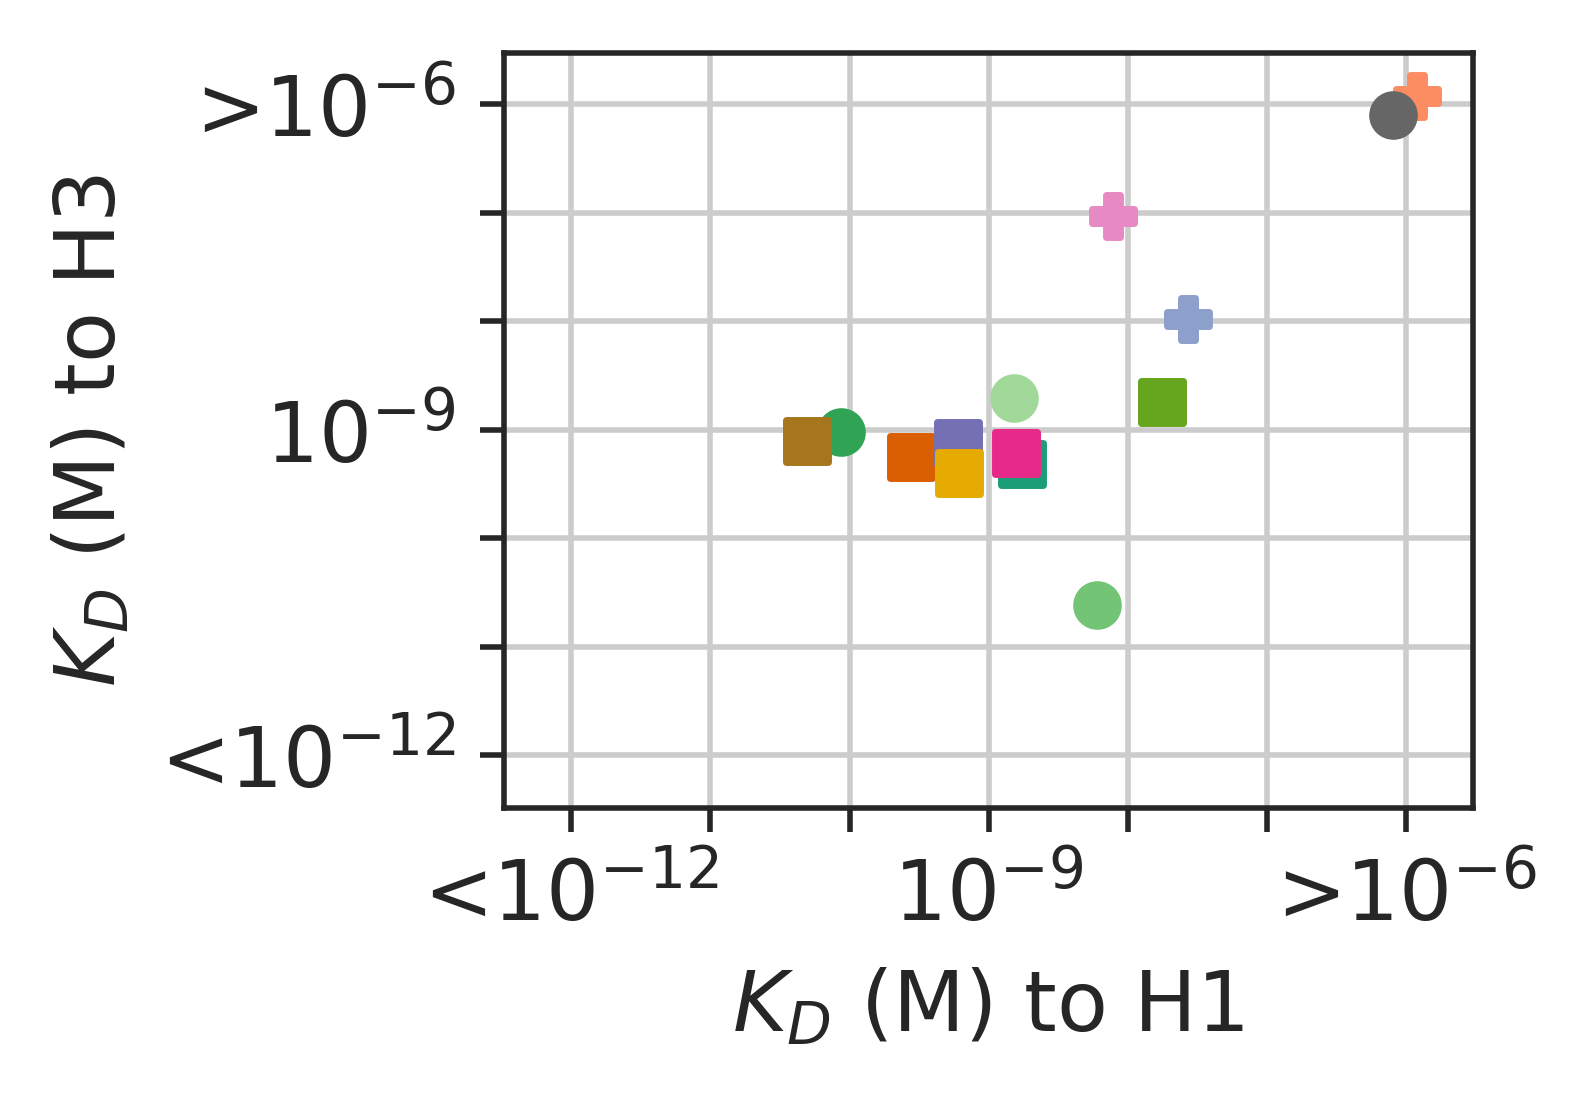

In [5]:
# selector = (Aff["Antigen"] == "H1 CA/07/09 monomer") & (Aff["Best"] == True)
# x = Aff.loc[selector].sort_values(by="Antibody")["K_D"]

# selector = (Aff["Antigen"] == "H3 Perth 09 monomer") & (Aff["Best"] == True)
# y = Aff.loc[selector].sort_values(by="Antibody")["K_D"]


selector = (Aff["Antigen"] == "H1 CA/07/09 monomer")
x = Aff.loc[selector].sort_values(by="Antibody").set_index("Antibody")

selector = (Aff["Antigen"] == "H3 Perth 09 monomer")
y = Aff.loc[selector].sort_values(by="Antibody").set_index("Antibody").loc[x.index]

names = x.index
names_clean = [name_to_name_clean[name] for name in names]
# names_clean = [name.replace("L3_", "") for name in names]
# names_clean = [name.replace("N6_", "") for name in names_clean]

markers = [name_to_marker[i] for i in names_clean]
colors = [name_to_color[i] for i in names_clean]

x = x["K_D"]
y = y["K_D"]

fig, ax = plt.subplots(1, 1, figsize=(2.5,2))

for x_i, y_i, marker_i, color_i, name_i in zip(x, y, markers, colors, names_clean):
    if name_i == "germline":
        # add jitter
        x_i = x_i - 0.2e-6
        y_i = y_i - 0.2e-6
    if name_i == "germline IGH":
        # add jitter
        x_i = x_i + 0.2e-6
        y_i = y_i + 0.2e-6
    ax.scatter(x_i, y_i, marker=marker_i, c=color_i)
    
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.33e-12, 3e-6)
ax.set_ylim(0.33e-12, 3e-6)
ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax.set_yticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax.set_xticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
ax.set_yticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
# ax.set_xticks([1e-12, 1e-10, 1e-8, 1e-6])
ax.grid(True)
ax.set_xlabel("$K_D$ (M) to H1")
ax.set_ylabel("$K_D$ (M) to H3")

# save_figure(fig, "Affinity_H1_H3_2009")

# Visualize affinities against childhood and adult H1 variants

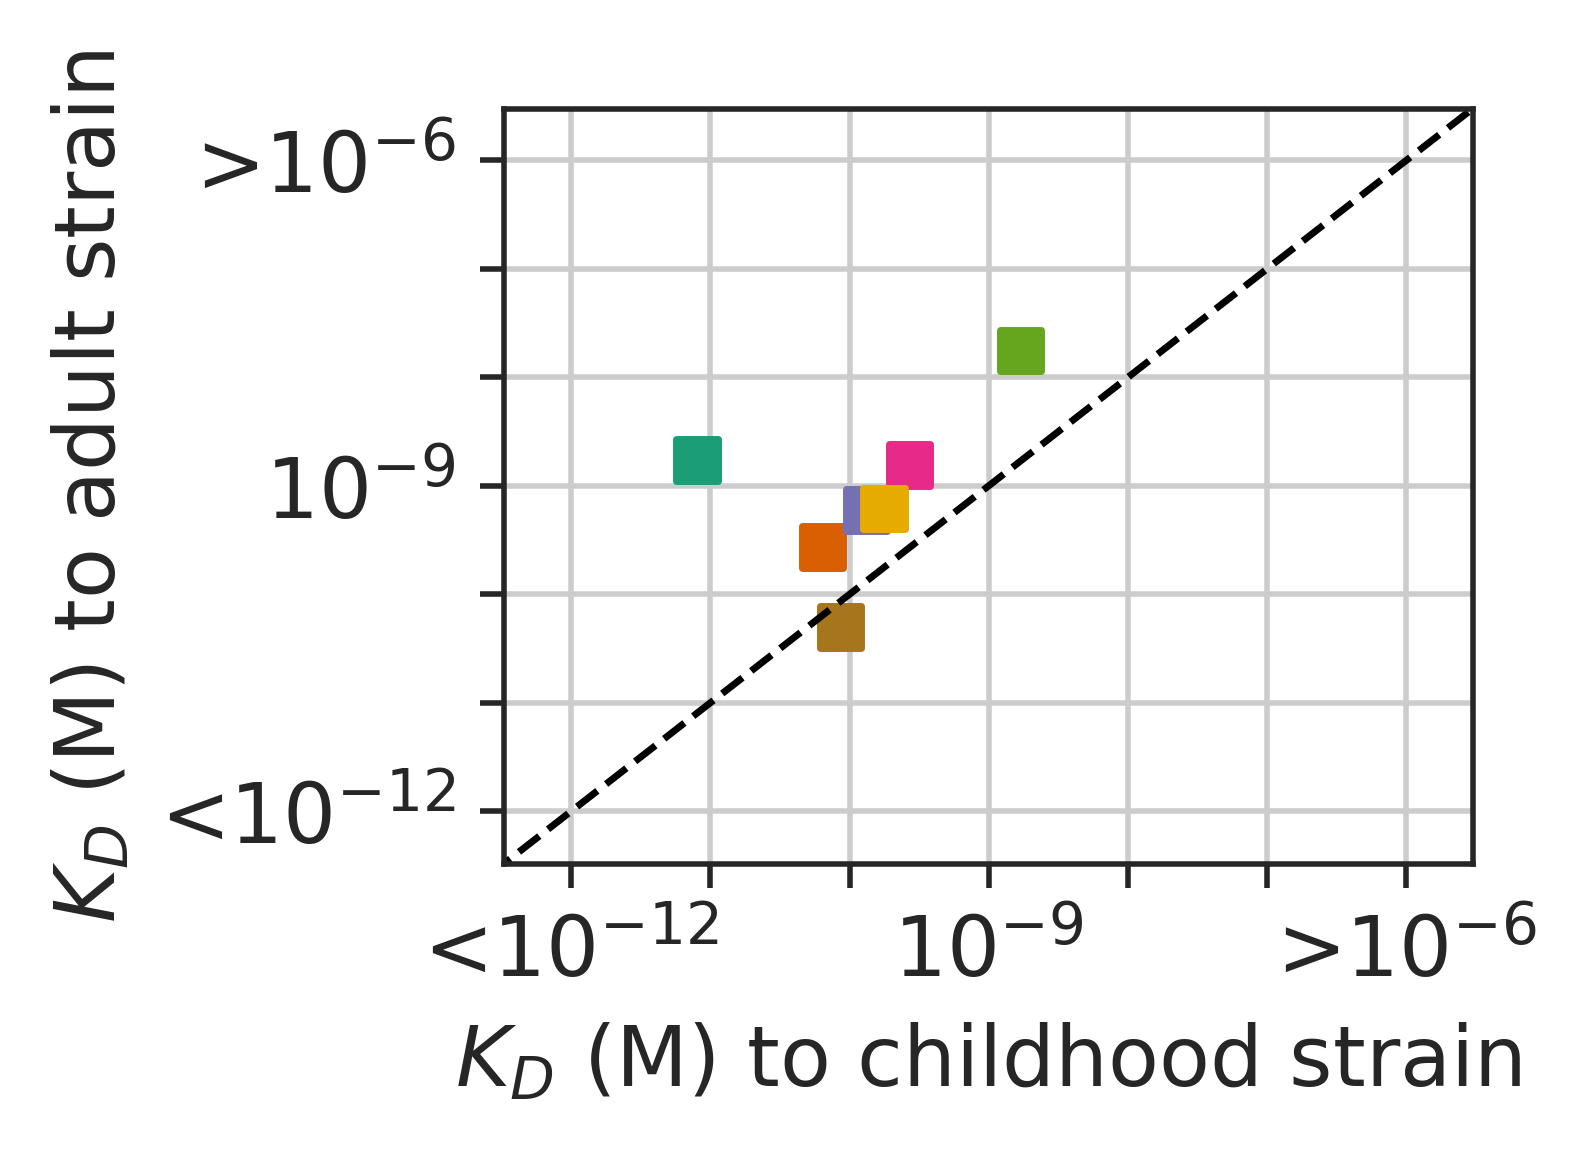

In [6]:
names_ordered = ["L3_N1", "L3_N2", "L3_N3", "L3_N4", "L3_N5", "L3_N6", "L3_N7"]

selector = (Aff["Antigen"] == "H1 NC 99 monomer")
x = Aff.loc[selector].set_index("Antibody").loc[names_ordered]["K_D"]

selector = (Aff["Antigen"] == "H1 CA/07/09 monomer")
y = Aff.loc[selector].set_index("Antibody").loc[names_ordered]["K_D"]

names_clean = [name.replace("L3_", "") for name in names_ordered]

markers = [name_to_marker[i] for i in names_clean]
colors = [name_to_color[i] for i in names_clean]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

ax.scatter(x, y, marker="s", c=colors)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.33e-12, 3e-6)
ax.set_ylim(0.33e-12, 3e-6)
ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax.set_yticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax.set_xticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
ax.set_yticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
ax.grid(True)
ax.set_xlabel("$K_D$ (M) to childhood strain")
ax.set_ylabel("$K_D$ (M) to adult strain")


x_line = np.logspace(-13, -5, 100)
y_line = x_line
ax.plot(x_line, y_line, "k--", lw=1)

# save_figure(fig, "Affinity_H1_childhood_adult")

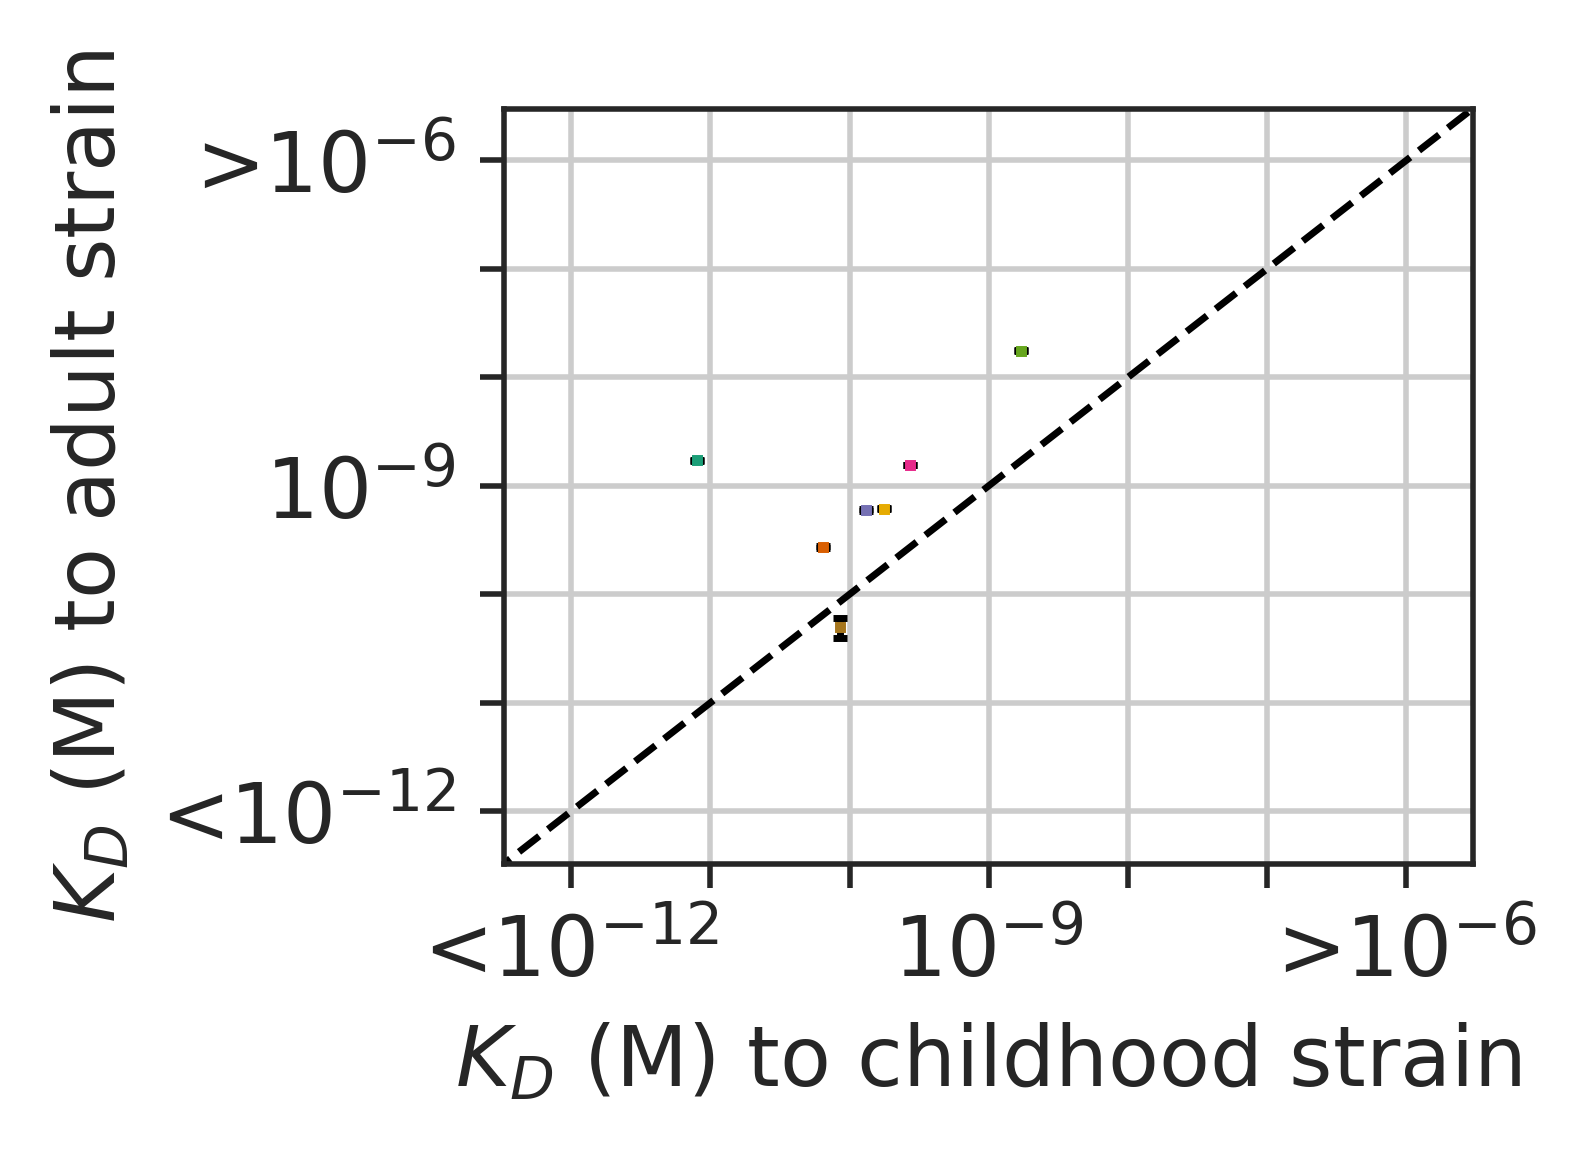

In [7]:
# Plot with error bars

names_ordered = ["L3_N1", "L3_N2", "L3_N3", "L3_N4", "L3_N5", "L3_N6", "L3_N7"]

selector = (Aff["Antigen"] == "H1 NC 99 monomer")
data_temp = Aff.loc[selector].set_index("Antibody").loc[names_ordered]
x = data_temp["K_D"]
xerr = data_temp["K_D error"]

selector = (Aff["Antigen"] == "H1 CA/07/09 monomer")
data_temp = Aff.loc[selector].set_index("Antibody").loc[names_ordered]
y = data_temp["K_D"]
yerr = data_temp["K_D error"]

names_clean = [name.replace("L3_", "") for name in names_ordered]
markers = [name_to_marker[i] for i in names_clean]
colors = [name_to_color[i] for i in names_clean]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

for x_i, y_i, xerr_i, yerr_i, marker_i, color_i, name_i in zip(x, y, xerr, yerr, markers, colors, names_clean):
    ax.errorbar(x_i, y_i, xerr=xerr_i, yerr=yerr_i, marker=marker_i, c=color_i, ecolor="k", capsize=1, capthick=1, elinewidth=1, markersize=0.5)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.33e-12, 3e-6)
ax.set_ylim(0.33e-12, 3e-6)
ax.set_xticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax.set_yticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
ax.set_xticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
ax.set_yticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
ax.grid(True)
ax.set_xlabel("$K_D$ (M) to childhood strain")
ax.set_ylabel("$K_D$ (M) to adult strain")

x_line = np.logspace(-13, -5, 100)
y_line = x_line
ax.plot(x_line, y_line, "k--", lw=1)

# save_figure(fig, "Affinity_H1_childhood_adult_errorbars")

In [8]:
print y/x

Antibody
L3_N1    215.000000
L3_N2      4.281250
L3_N3      4.522727
L3_N4      5.777778
L3_N5     10.414201
L3_N6      3.500000
L3_N7      0.579070
Name: K_D, dtype: float64


In [9]:
print np.mean(y/x), np.std(y/x)

34.867860857339835 73.58943416231924


# Visualize all measured affinities as barplot

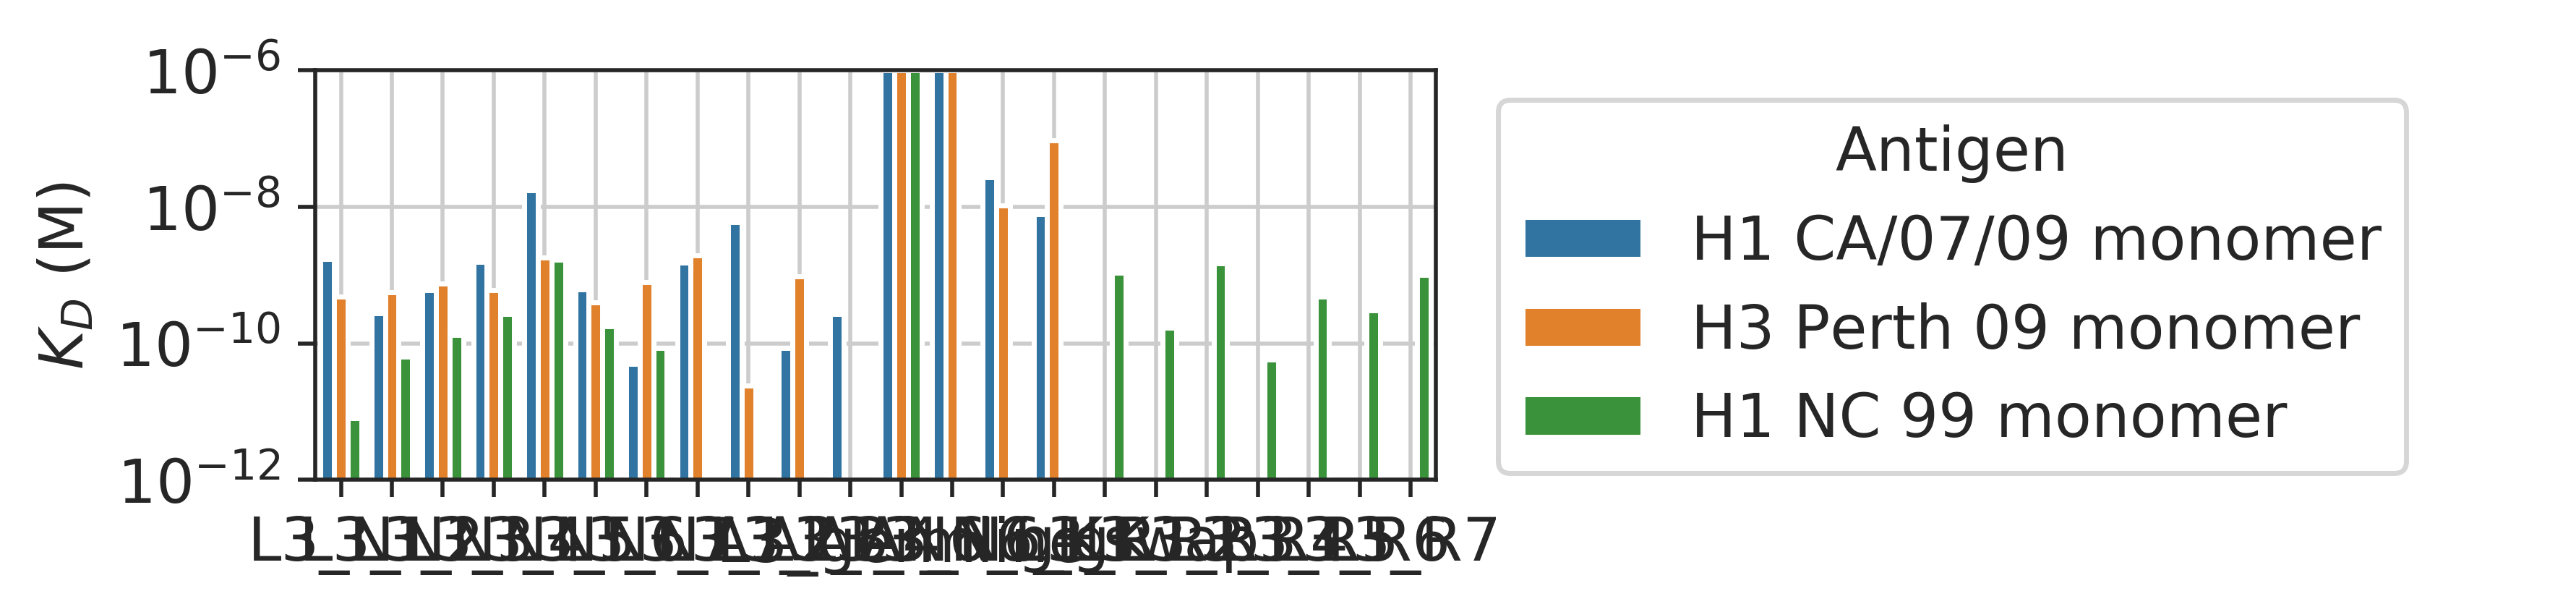

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(4,1.5))
sns.barplot(ax=ax, data=Aff, x="Antibody", y="K_D", hue="Antigen")
ax.set_yscale("log")
ax.set_ylim(1e-12, 1e-6)
ax.set_xlabel("")
ax.set_ylabel("$K_D$ (M)")
# ax.set_xticklabels(["N1", "N2", "N3", "N4", "N5", "N6", "N7"])
ax.grid(True)
ax.legend().set_visible(False)
fig.legend(loc="center", bbox_to_anchor=(1.35, 0.6), title="Antigen")
# save_figure(fig, "Affinity_barplot")

# Visualize affinity versus mutation count

In [11]:
# Read sequences

from Bio import SeqIO

infile = data_dir + "L3_recombinant.fasta"

seqs = SeqIO.parse(open(infile), "fasta")

seqs_dict = {}

for seq in seqs:
    seqs_dict[seq.name] = str(seq.seq)

In [12]:
# Calculate distance from germline for each sequence

def hamming_distance(s1, s2):
    """ Calculate Hamming distance between equal-length strings """
    assert len(s1) == len(s2)
    d = 0
    L = len(s1)
    for i in range(L):
        if s1[i] != s2[i]:
            d += 1
    return d

dists = {}

for name, seq in sorted(seqs_dict.items()):
    d = hamming_distance(seqs_dict["L3_germline"], seq)
    dists[name] = d
    
seqs_dists_germline = pd.DataFrame(index=dists.keys())
seqs_dists_germline["subs_to_germline"] = dists.values()
seqs_dists_germline

,subs_to_germline
L3_R1,20
L3_R3,21
L3_R2,19
L3_R5,31
L3_R4,20
L3_R7,34
L3_R6,39
L3_germline,0
L3_N5,32
L3_N4,33


/scratch/resources/anaconda2/envs/py27/lib/python2.7/site-packages/ipykernel_launcher.py:7: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  import sys


SpearmanrResult(correlation=0.257994796054888, pvalue=0.37317568471880735)


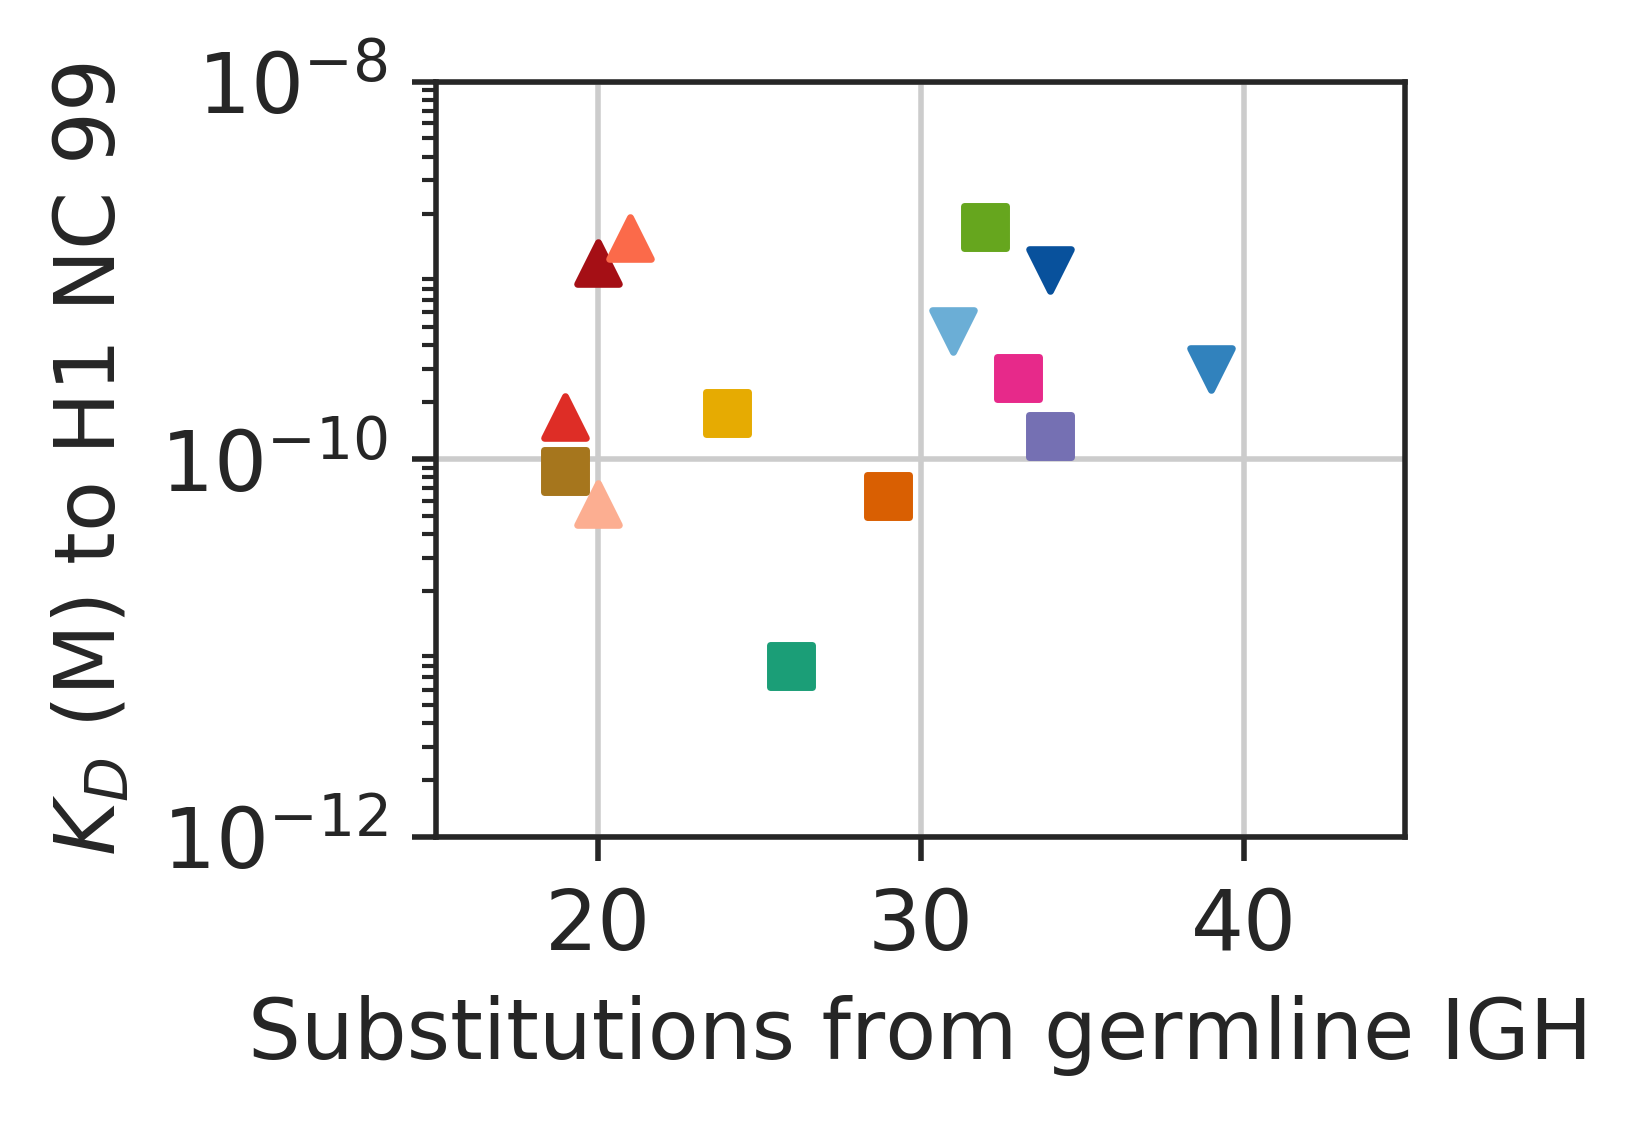

In [13]:
# Select data

x = seqs_dists_germline["subs_to_germline"]
x = x.drop("L3_germline")

selector = (Aff["Antigen"] == "H1 NC 99 monomer")
y = Aff.loc[selector].set_index("Antibody").loc[x.index]["K_D"]

# Remove nan
y_clean = y[~np.isnan(y)] # remove nan
x_clean = x[y_clean.index]

names_clean = [name.replace("L3_", "") for name in x.index]
markers = [name_to_marker[i] for i in names_clean]
colors = [name_to_color[i] for i in names_clean]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

for x_i, y_i, marker_i, color_i, name_i in zip(x, y, markers, colors, names_clean):
    ax.scatter(x_i, y_i, marker=marker_i, c=color_i)

ax.set_yscale("log")
ax.set_xlim(15, 45)
ax.set_ylim(1e-12, 1e-8)
ax.set_yticks([1e-12, 1e-10, 1e-8])
ax.set_yticklabels(["$10^{-12}$", "$10^{-10}$", "$10^{-8}$"])
ax.grid(True)
ax.set_xlabel("Substitutions from germline IGH")
ax.set_ylabel("$K_D$ (M) to H1 NC 99")

save_figure(fig, "Affinity_SubsFromGermline_H1_NC_99")

print scipy.stats.spearmanr(x_clean, y_clean)

In [14]:
names_Abs_focal = ['L3_N1', 'L3_N2', 'L3_N3', 'L3_N4', 'L3_N5', 'L3_N6', 'L3_N7']
print "Mean", seqs_dists_germline.loc[names_Abs_focal].mean()
print "STD", seqs_dists_germline.loc[names_Abs_focal].std()

Mean subs_to_germline    28.142857
dtype: float64
STD subs_to_germline    5.45981
dtype: float64


# Visualize kinetic parameters (k_on, k_off)

Text(0,0.5,'$k_{off}$ $(s^{-1})$')

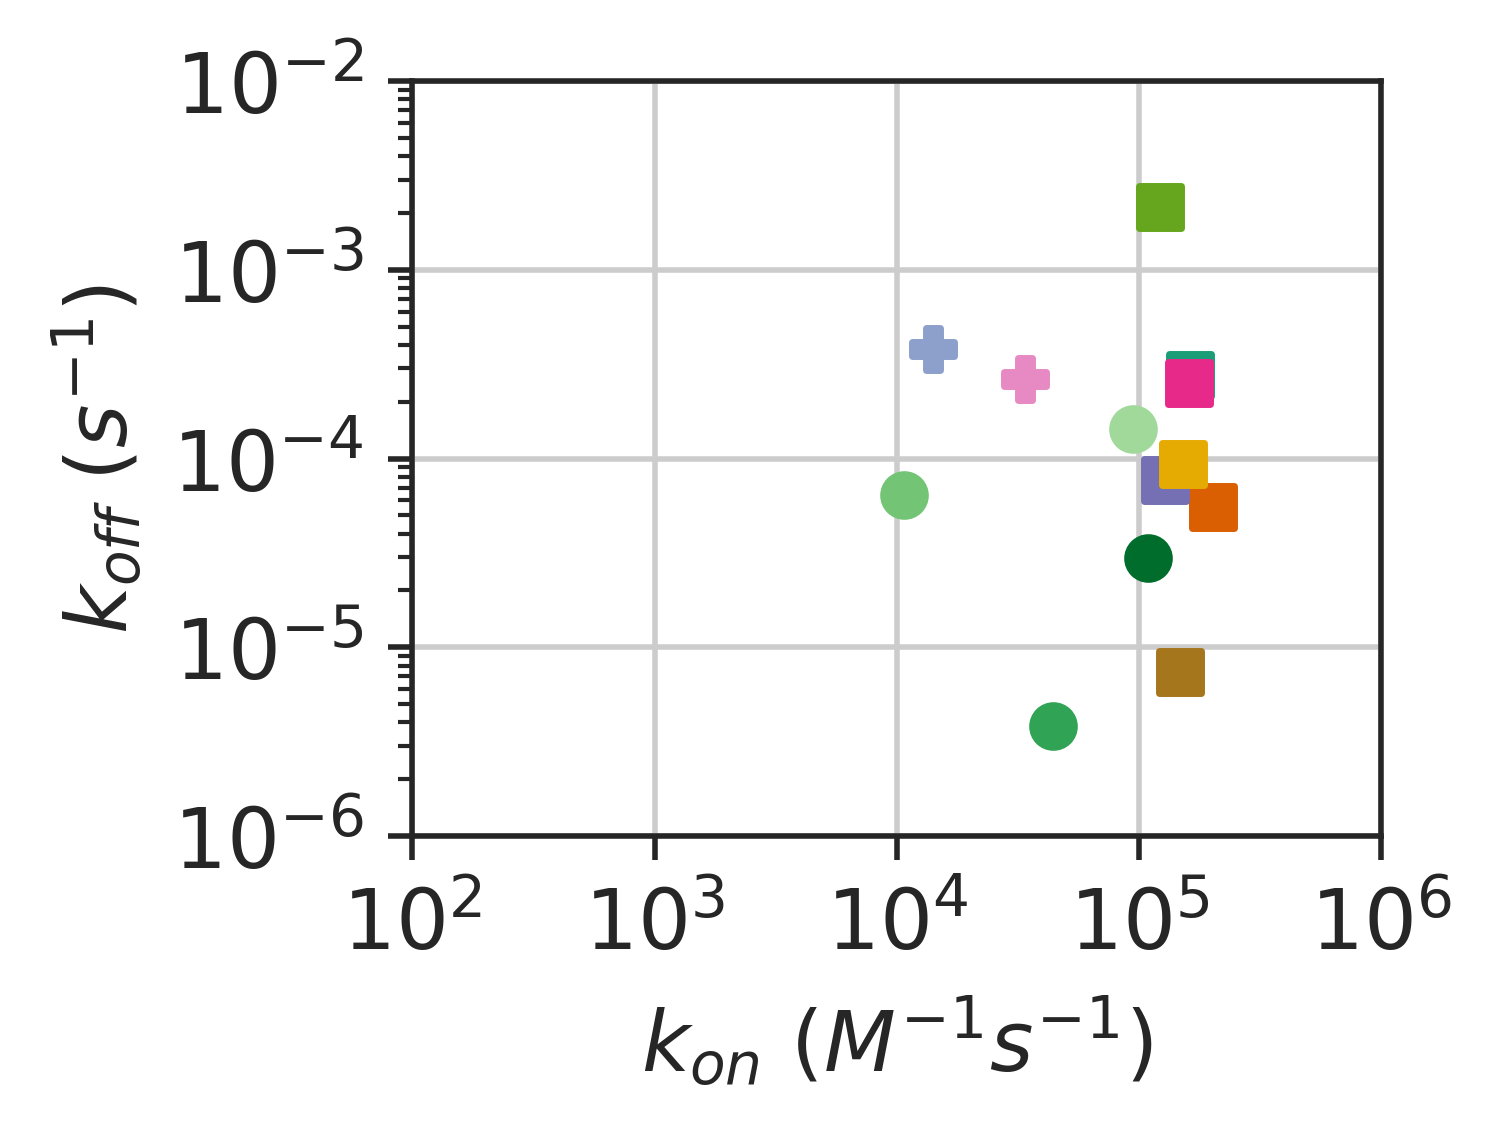

In [15]:
names_Abs_focal = ['L3_N1', 'L3_N2', 'L3_N3', 'L3_N4', 'L3_N5', 'L3_N6', 'L3_N7', 'L3_A1', 'L3_A2', 'L3_A3', 'L3_A4', 'L3_germline', 'L3_N6_gH', 'L3_N6_gK', 'L3_N6_Kswap']
selector = (Aff["Antibody"].isin(names_Abs_focal)) & (Aff["Antigen"] == "H1 CA/07/09 monomer")

data_temp = Aff.loc[selector].dropna(subset=["k_on", "k_off"])

x = data_temp["k_on"]
y = data_temp["k_off"]

names_clean = [name_to_name_clean[name] for name in data_temp.Antibody]
markers = [name_to_marker[i] for i in names_clean]
colors = [name_to_color[i] for i in names_clean]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

for x_i, y_i, marker_i, color_i, name_i in zip(x, y, markers, colors, names_clean):
    ax.scatter(x_i, y_i, marker=marker_i, c=color_i)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(-5, 45)
ax.set_xlim(1e2, 1e6)
ax.set_ylim(1e-6, 1e-2)
ax.set_xticks([1e2, 1e3, 1e4, 1e5, 1e6])
# ax.set_yticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
# ax.set_yticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
ax.grid(True)
ax.set_xlabel("$k_{on}$" + " " + "$(M^{-1} s^{-1})$")
ax.set_ylabel("$k_{off}$" + " " + "$(s^{-1})$")

# save_figure(fig, "Affinity_KineticParams_H1_CA_09")

# print scipy.stats.spearmanr(x_clean, y_clean)

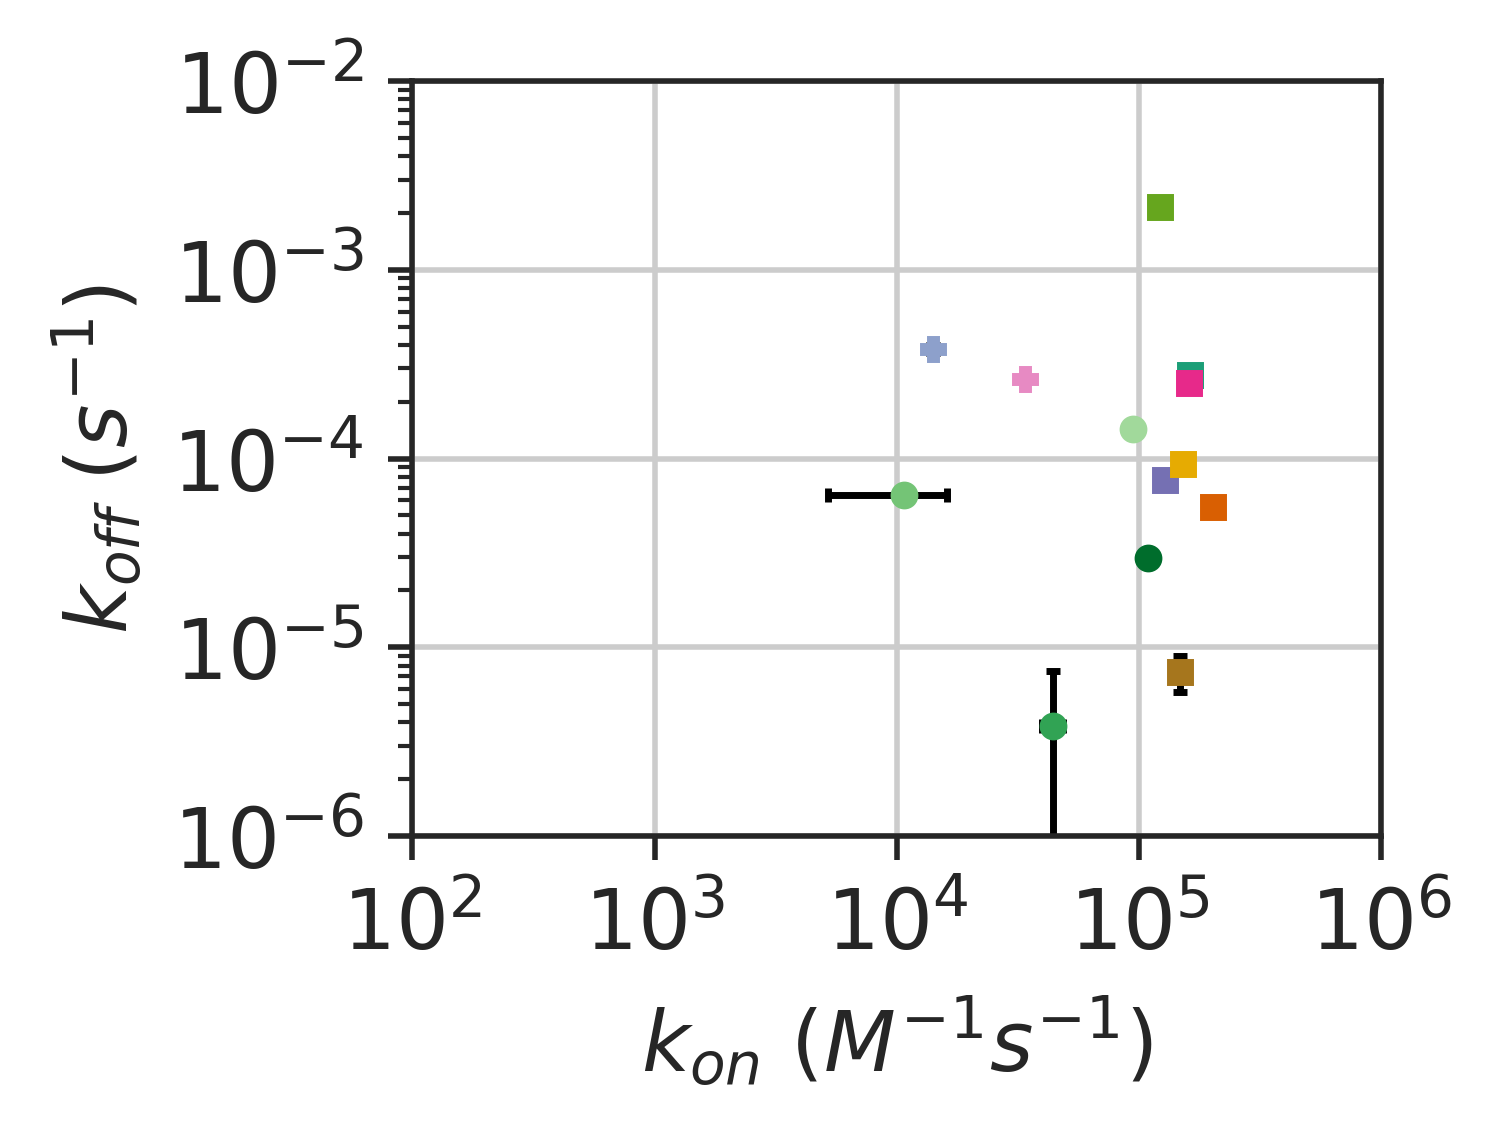

In [16]:
# Plot with error bars

names_Abs_focal = ['L3_N1', 'L3_N2', 'L3_N3', 'L3_N4', 'L3_N5', 'L3_N6', 'L3_N7', 'L3_A1', 'L3_A2', 'L3_A3', 'L3_A4', 'L3_germline', 'L3_N6_gH', 'L3_N6_gK', 'L3_N6_Kswap']
selector = (Aff["Antibody"].isin(names_Abs_focal)) & (Aff["Antigen"] == "H1 CA/07/09 monomer")

data_temp = Aff.loc[selector].dropna(subset=["k_on", "k_off"])

x = data_temp["k_on"]
y = data_temp["k_off"]

xerr = data_temp["k_on error"]
yerr = data_temp["k_off error"]

names_clean = [name_to_name_clean[name] for name in data_temp.Antibody]
markers = [name_to_marker[i] for i in names_clean]
colors = [name_to_color[i] for i in names_clean]

fig, ax = plt.subplots(1, 1, figsize=(2.5, 2))

for x_i, y_i, xerr_i, yerr_i, marker_i, color_i, name_i in zip(x, y, xerr, yerr, markers, colors, names_clean):
    # ax.scatter(x_i, y_i, marker=marker_i, c=color_i)
    ax.errorbar(x_i, y_i, xerr=xerr_i, yerr=yerr_i, marker=marker_i, c=color_i, ecolor="k", capsize=1, capthick=1, elinewidth=1, markersize=3)

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim(-5, 45)
ax.set_xlim(1e2, 1e6)
ax.set_ylim(1e-6, 1e-2)
ax.set_xticks([1e2, 1e3, 1e4, 1e5, 1e6])
# ax.set_yticks([1e-12, 1e-11, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6])
# ax.set_yticklabels(["<$10^{-12}$", "", "", "$10^{-9}$", "", "", ">$10^{-6}$"])
ax.grid(True)
ax.set_xlabel("$k_{on}$" + " " + "$(M^{-1} s^{-1})$")
ax.set_ylabel("$k_{off}$" + " " + "$(s^{-1})$")

save_figure(fig, "Affinity_KineticParams_H1_CA_09_errorbars")

# print scipy.stats.spearmanr(x_clean, y_clean)

# Visualize binding of L3_germline

In [17]:
infile = data_dir + "L3_germline_kinetics.txt"
usecols = ["Time1", "Data1"]
df_temp = pd.read_csv(infile, sep="\t", header=0, skiprows=7, index_col=None, usecols=usecols)
print df_temp.shape
df_temp.head()

(4500, 2)


,Time1,Data1
0,480.03,0.000000
1,480.23,-0.000273
2,480.43,-0.000766
3,480.63,-0.000895
4,480.83,-0.001264


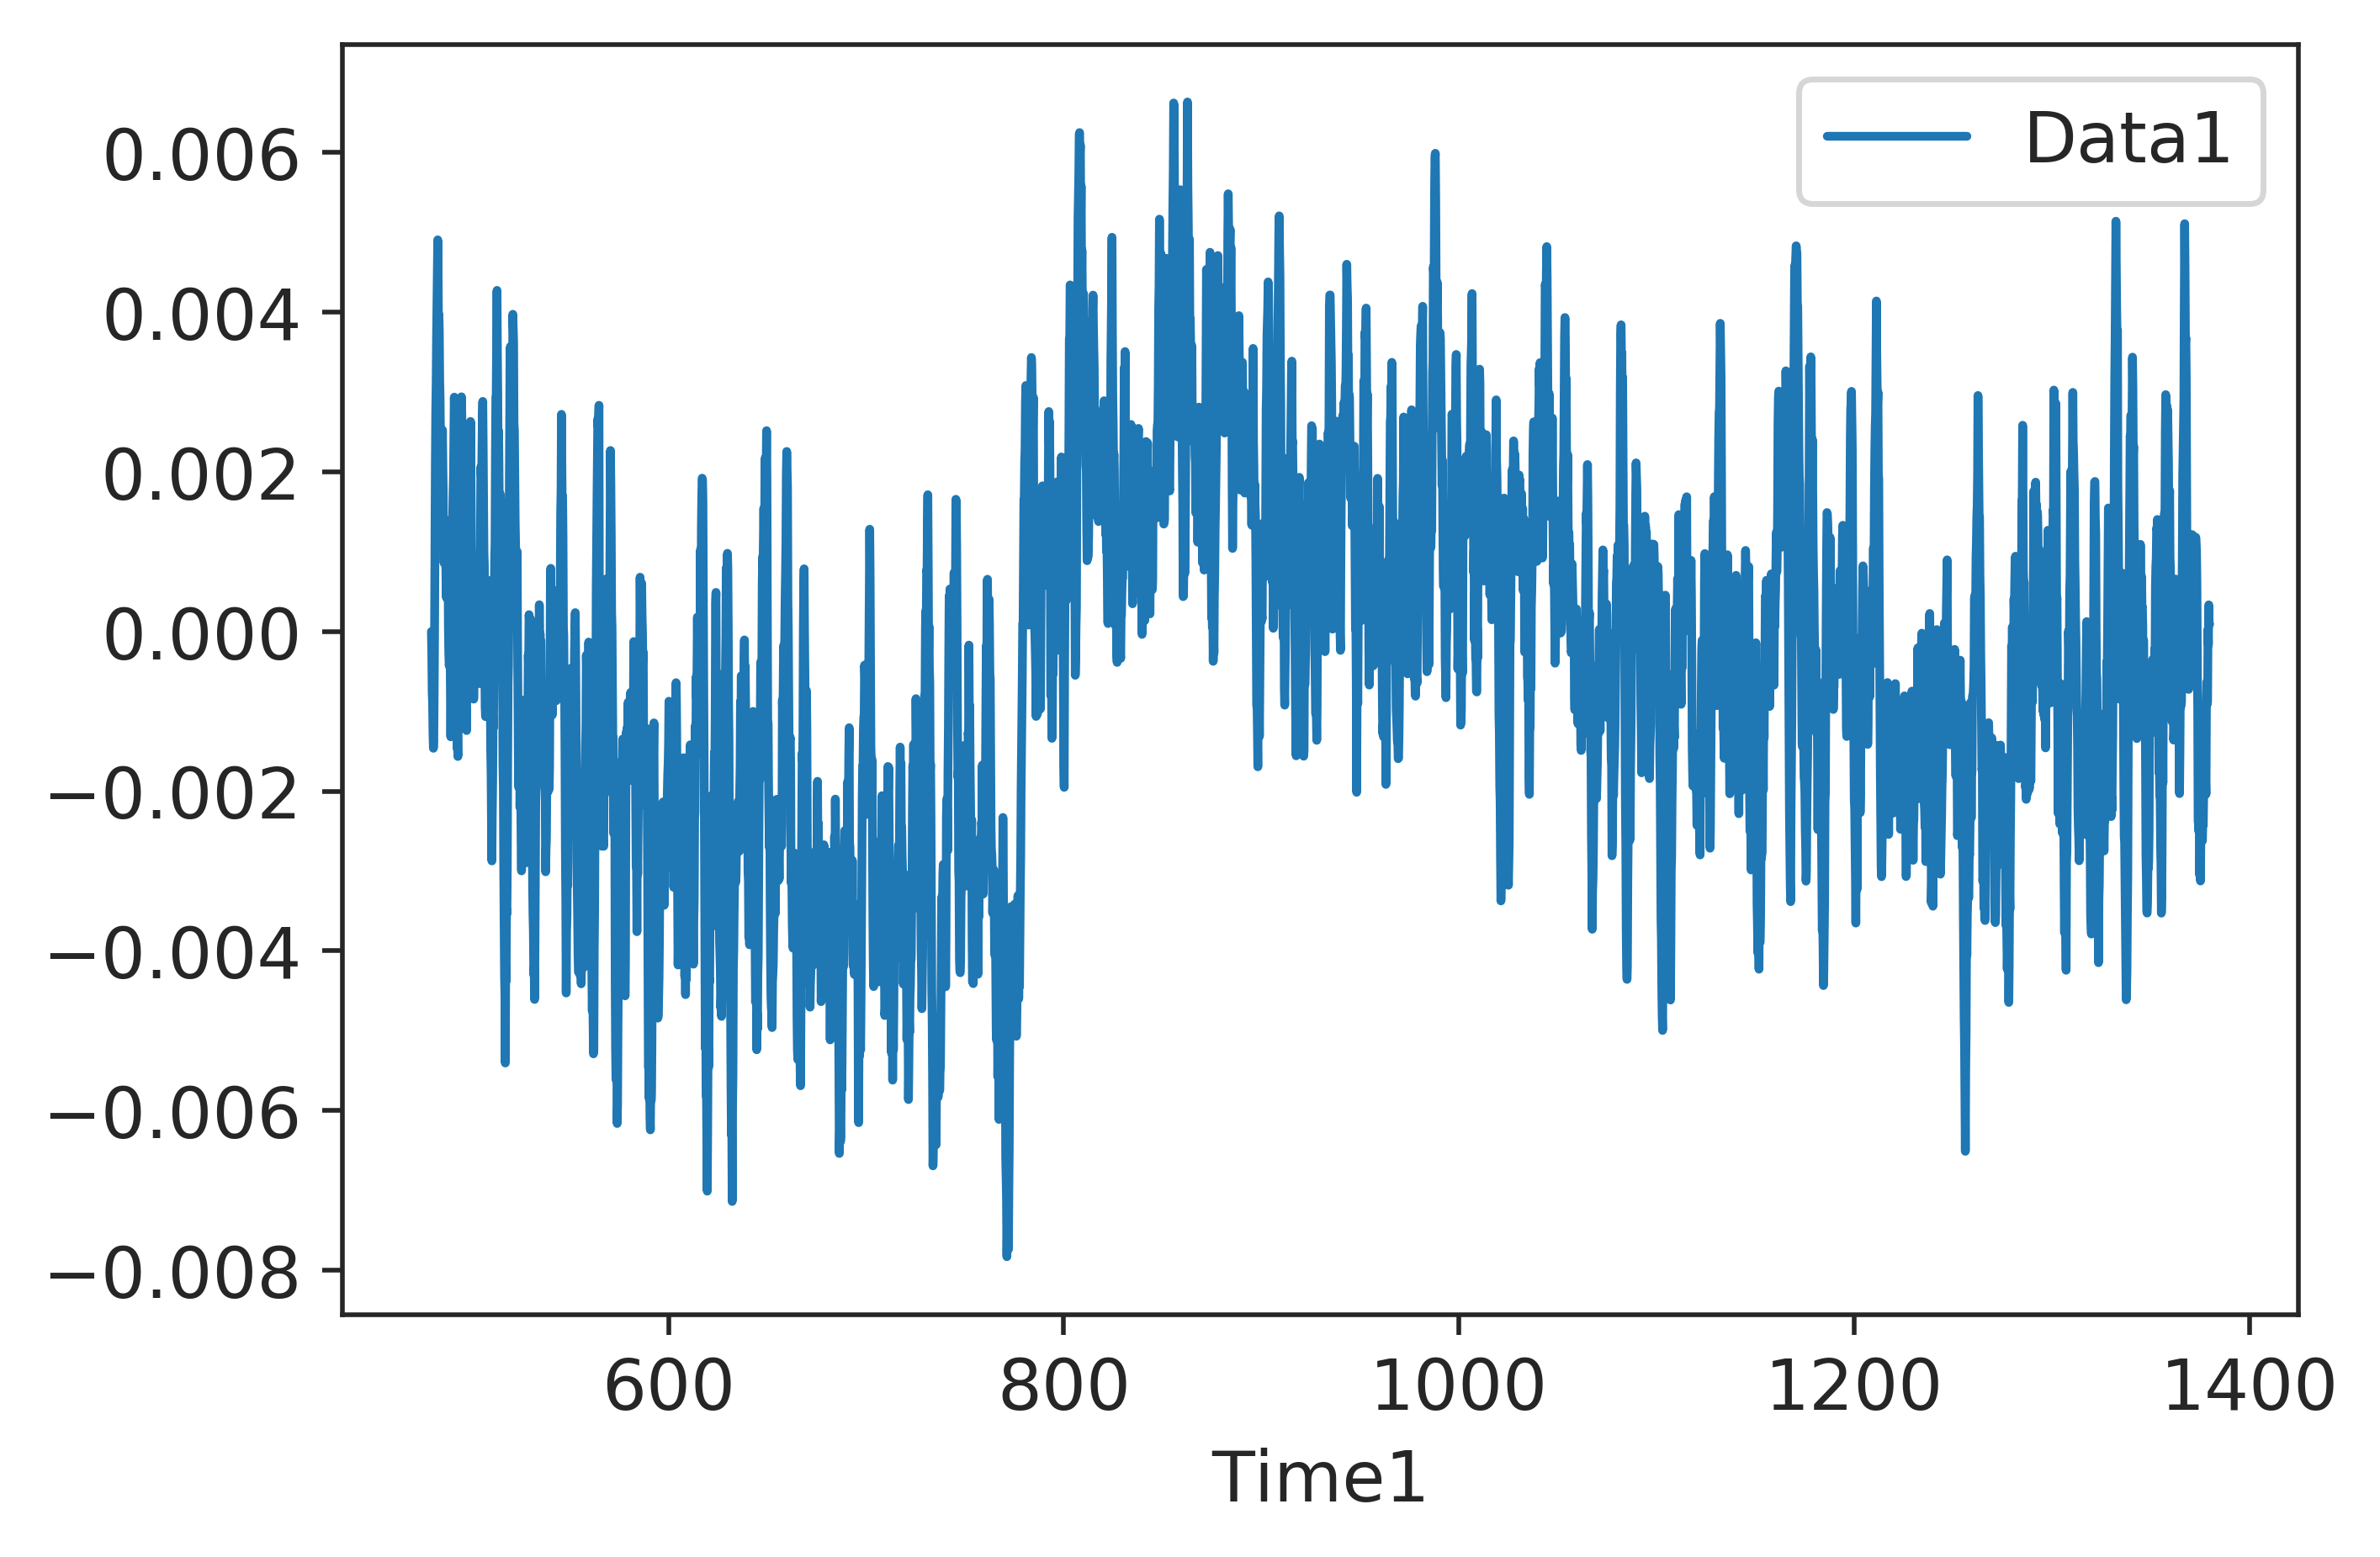

In [18]:
df_temp.plot(x="Time1", y="Data1")